In [31]:
import mdtraj as md
import numpy as np

import re
import numpy
from tqdm import tqdm
from pathlib import Path
from natsort import natsorted

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [55]:
ftraj_dir = Path('ftraj_egfr')
ftraj_f = natsorted([ftraj for ftraj in ftraj_dir.rglob('run*-clone?_dunbrack.npy')])
ftrajs = [np.load(file) for file in ftraj_f]
ftraj = np.concatenate(ftrajs)
ftraj.shape

(36635996, 9)

In [215]:
def subsample_ftraj(ftrajs, stride=1000):
    cummulative_lens = np.cumsum([len(ftraj) for ftraj in ftrajs])
    cat_ftrajs = np.concatenate(ftrajs)
    subsampled_ftrajs = cat_ftrajs[::stride]

    file_index = [np.where(cummulative_lens - i*stride >= 0)[0][0] for i in range(len(subsampled_ftrajs))]

    cummulative_lens = np.insert(cummulative_lens, 0, -1)
    frame_index = [i*stride - cummulative_lens[file_index[i]] - 1 for i in range(len(subsampled_ftrajs))]

    mapping = np.array([file_index, frame_index])
    return subsampled_ftrajs, mapping

In [226]:
subsampled_ftraj, mapping = subsample_ftraj(ftrajs, stride=1000)
subsampled_ftraj.dump('subsampled_ftraj.npy')
mapping.dump('mapping.npy') 

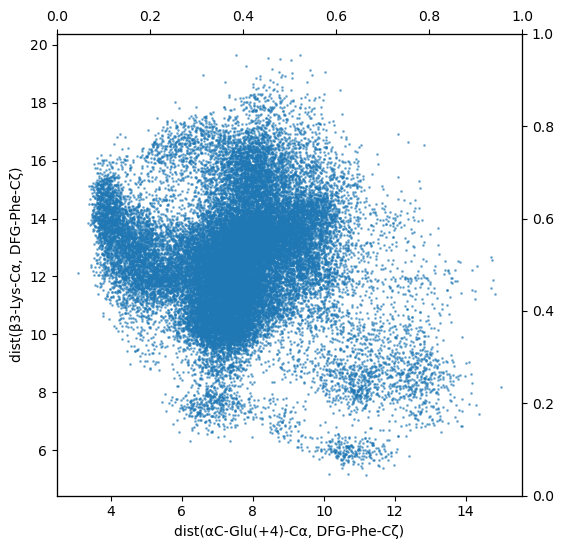

In [225]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(subsampled_ftraj[:, 0]*10, subsampled_ftraj[:, 1]*10, s=1, alpha=0.5)
ax.set_xlabel('dist(αC-Glu(+4)-Cα, DFG-Phe-Cζ)')
ax.set_ylabel('dist(β3-Lys-Cα, DFG-Phe-Cζ)')

ax_top = ax.twiny()
ax_right = ax.twinx()

plt.show()

Apply average linkage hierarchical clustering to the point cloud:

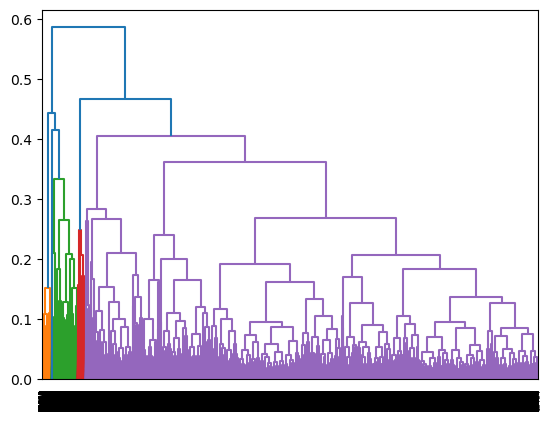

In [227]:
from scipy.cluster.hierarchy import linkage, dendrogram

stride = 1000
Z = linkage(subsampled_ftraj[:, :2], method='average')
R = dendrogram(Z)

In [228]:
from scipy.cluster.hierarchy import fcluster

cluster_labels = fcluster(Z, 3, criterion='maxclust')
cluster1_points = subsampled_ftraj[:, :2][cluster_labels == 1]
cluster2_points = subsampled_ftraj[:, :2][cluster_labels == 2]
cluster3_points = subsampled_ftraj[:, :2][cluster_labels == 3]

cluster_labels.dump('spatial_group_labels.npy')

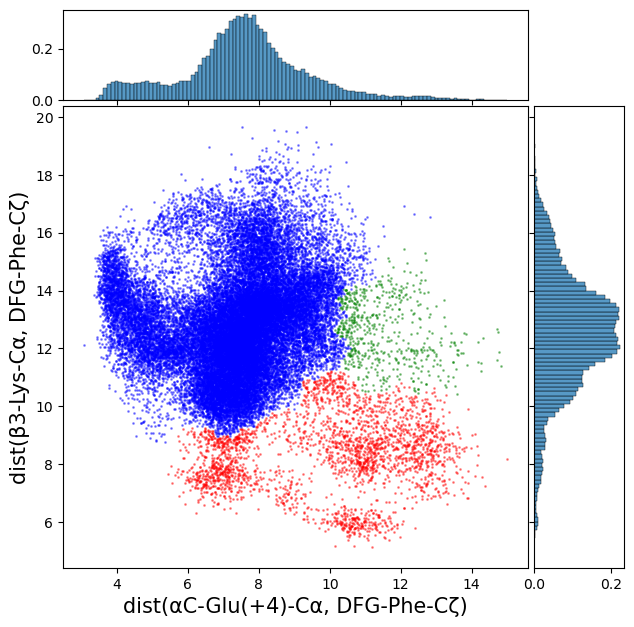

: 

In [230]:
# Top left -- DFG-in
# Bottom right -- DFG-out
# Bottom left -- DFG-inter

fig, ax = plt.subplots(figsize=(6, 6))
intx_ax = fig.add_axes([ax.get_position().x0, ax.get_position().y1 + 0.01,
                        ax.get_position().width, 0.15])
inty_ax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0,
                        0.15, ax.get_position().height])

ax.scatter(cluster1_points[:,0]*10, cluster1_points[:,1]*10, s=1, alpha=0.4, c='r')
ax.scatter(cluster2_points[:,0]*10, cluster2_points[:,1]*10, s=1, alpha=0.4, c='g')
ax.scatter(cluster3_points[:,0]*10, cluster3_points[:,1]*10, s=1, alpha=0.4, c='b')

sns.histplot(x=subsampled_ftraj[:, 0]*10, stat='density', lw=3, ax=intx_ax)
sns.histplot(y=subsampled_ftraj[:, 1]*10, stat='density', lw=3, ax=inty_ax)

ax.set_xlabel('dist(αC-Glu(+4)-Cα, DFG-Phe-Cζ)', fontsize=15)xc
ax.set_ylabel('dist(β3-Lys-Cα, DFG-Phe-Cζ)', fontsize=15)
intx_ax.set_ylabel('')
intx_ax.tick_params(labelbottom=False)
inty_ax.set_xlabel('')
inty_ax.tick_params(labelleft=False)

plt.savefig('plots/dist_clusters_EGFR.png', dpi=300, transparent=True)
plt.show()

In [137]:
# Testing some structures with defined DFG conformations from the KLIFS database

test_out1 = md.load('test_DFG/out_2rf9_chainB.pdb')
test_out2 = md.load('test_DFG/out_4i20_chainA.pdb')
test_in1 = md.load('test_DFG/in_1m14_chainA.pdb')
test_in2 = md.load('test_DFG/in_1m17_altA_chainA.pdb')
test_in3 = md.load('test_DFG/in_2gs6_chainA.pdb')
test_inter1 = md.load('test_DFG/inter_4g5p_chainB.pdb')

/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [147]:
met_ca_id = 372
phe_cz_id = 1069
lys_ca_id = 268

d = md.compute_distances(test_out1, [[met_ca_id, phe_cz_id], [lys_ca_id, phe_cz_id]])
d

array([[1.3676997 , 0.76666176]], dtype=float32)

In [148]:
met_ca_id = 513
phe_cz_id = 1241
lys_ca_id = 345

d = md.compute_distances(test_out2, [[met_ca_id, phe_cz_id], [lys_ca_id, phe_cz_id]])
d

array([[1.5068259 , 0.40912116]], dtype=float32)

In [149]:
met_ca_id = 546
phe_cz_id = 1274
lys_ca_id = 378

d = md.compute_distances(test_in1, [[met_ca_id, phe_cz_id], [lys_ca_id, phe_cz_id]])
d

array([[0.6200678, 1.5305007]], dtype=float32)

In [150]:
met_ca_id = 546
phe_cz_id = 1274
lys_ca_id = 378

d = md.compute_distances(test_in2, [[met_ca_id, phe_cz_id], [lys_ca_id, phe_cz_id]])
d

array([[0.59859896, 1.4849942 ]], dtype=float32)

In [151]:
met_ca_id = 532
phe_cz_id = 1260
lys_ca_id = 389

d = md.compute_distances(test_in3, [[met_ca_id, phe_cz_id], [lys_ca_id, phe_cz_id]])
d

array([[0.6164708, 1.5782894]], dtype=float32)

In [157]:
met_ca_id = 542
phe_cz_id = 1271
lys_ca_id = 374

d = md.compute_distances(test_inter1, [[met_ca_id, phe_cz_id], [lys_ca_id, phe_cz_id]])
d

array([[0.8694236, 0.4057688]], dtype=float32)